In [1]:
using Gen
using PyPlot
const plt = PyPlot

PyPlot

In [2]:
"""
    line_model(xs)

Generate a probabilistic model for a linear fit to some data `xs` given by
y(x) = mx + b + ϵ where m is the slope, b in the intercept, and ϵ is some noise.
"""
@gen function line_model(xs)
    m ~ normal(0, 1)
    b ~ normal(0, 2)
    ϵ ~ gamma(1, 1)
    
    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(m*x + b, ϵ)
    end
    
    return nothing
end

line_model

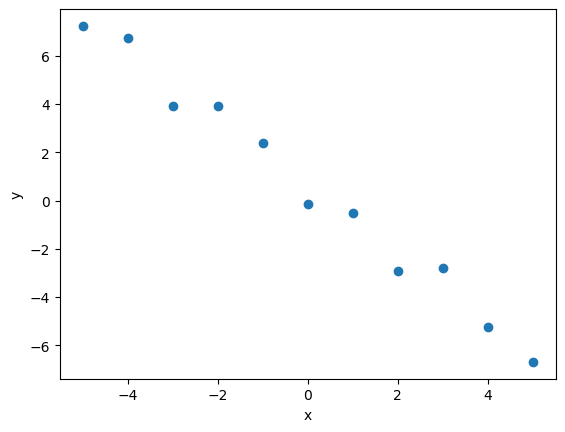

PyObject Text(24.000000000000007, 0.5, 'y')

In [28]:
# Parameters used to generate line data (and which we will try to infer).
m′ = -1.4
b′ = 0.5
ϵ′ = 0.4

xs = -5.0:1.0:5.0 |> collect
ys = @.m′*xs + b′ + ϵ′*randn()

plt.scatter(xs, ys)
plt.xlabel("x")
plt.ylabel("y")

In [30]:
"""
    infer_line_model_parameters_one_chain_per_sample(xs, ys; n_samples, mh_iters)

Infer the slope, intercept, and noise of a line model describing the dataset (`xs`, `ys`)
returning a 3-tuple (ms, bs, ϵs) containing `n_samples` samples for each line model parameter.
Each sample is generated using Metropolis-Hastings with `mh_iters` iterations.
"""
function infer_line_model_parameters_one_chain_per_sample(xs, ys; n_samples, mh_iters)
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    line_model_params = Gen.select(:m, :b, :ϵ)
    
    ms = zeros(n_samples)
    bs = zeros(n_samples)
    ϵs = zeros(n_samples)
    
    for n in 1:n_samples
        trace, _ = Gen.generate(line_model, (xs,), observations)
        for i in 1:mh_iters
            trace, _ = metropolis_hastings(trace, line_model_params)
        end
        
        choices = Gen.get_choices(trace)
        ms[n] = choices[:m]
        bs[n] = choices[:b]
        ϵs[n] = choices[:ϵ]
    end
    
    return ms, bs, ϵs
end

infer_line_model_parameters_one_chain_per_sample

In [104]:
function plot_inference!(axes, xs, ys, ms, bs, ϵs, truth, bins)
    m′, b′, ϵ′ = truth
    
    # Trace plots of MCMC draws
    axes[1, 1].plot(ms)
    axes[1, 1].set_xlabel("iteration")
    axes[1, 1].set_ylabel("m")

    axes[1, 2].plot(bs)
    axes[1, 2].set_xlabel("iteration")
    axes[1, 2].set_ylabel("b")

    axes[1, 3].plot(ϵs)
    axes[1, 3].set_xlabel("iteration")
    axes[1, 3].set_ylabel("ϵ")

    # Parameter posterior pdfs
    axes[2, 1].hist(ms, label="posterior", bins=bins, density=true)
    axes[2, 1].set_xlabel("m")
    axes[2, 1].set_ylabel("p(m)")

    axes[2, 2].hist(bs, label="posterior", bins=bins, density=true)
    axes[2, 2].set_xlabel("b")
    axes[2, 2].set_ylabel("p(b)")

    axes[2, 3].hist(ϵs, label="posterior", bins=bins, density=true)
    axes[2, 3].set_xlabel("ϵ")
    axes[2, 3].set_ylabel("p(ϵ)")
    
    # Overlay some priors
    normal_pdf(x; μ, σ) = exp(Gen.logpdf(Gen.normal, x, μ, σ))
    gamma_pdf(x; k, θ) = exp(Gen.logpdf(Gen.gamma, x, k, θ))
    
    m_xs = range(minimum(ms), maximum(ms), length=1000)
    m_ys = @. normal_pdf(m_xs, μ=0.0, σ=1.0)
    axes[2, 1].plot(m_xs, m_ys, label="prior")
    
    b_xs = range(minimum(bs), maximum(bs), length=1000)
    b_ys = @. normal_pdf(b_xs, μ=0.0, σ=2.0)
    axes[2, 2].plot(b_xs, b_ys, label="prior")
    
    ϵ_xs = range(minimum(ϵs), maximum(ϵs), length=1000)
    ϵ_ys = @. gamma_pdf(ϵ_xs, k=1.0, θ=1.0)
    axes[2, 3].plot(ϵ_xs, ϵ_ys, label="prior")
    
    # Show truth values
    axes[2, 1].axvline(m′, label="truth", color="tab:red", linestyle="--")
    axes[2, 2].axvline(b′, label="truth", color="tab:red", linestyle="--")
    axes[2, 3].axvline(ϵ′, label="truth", color="tab:red", linestyle="--")
    
    # Should probably add a legend
    axes[2, 3].legend(loc="best", frameon=false)
    
    return nothing
end

plot_inference! (generic function with 2 methods)

In [105]:
function infer_and_plot_one_chain_per_sample(xs, ys; n_samples, mh_iters, truth, bins=10)
    ms, bs, ϵs = infer_line_model_parameters_one_chain_per_sample(xs, ys, n_samples=n_samples, mh_iters=mh_iters)
    
    fig, axes = PyPlot.subplots(nrows=2, ncols=3, figsize=(16, 9))
    fig.suptitle("One chain per sample ($n_samples samples, $mh_iters MH iterations)")

    plot_inference!(axes, xs, ys, ms, bs, ϵs, truth, bins)
    
    return ms, bs, ϵs
end

infer_and_plot_one_chain_per_sample (generic function with 1 method)

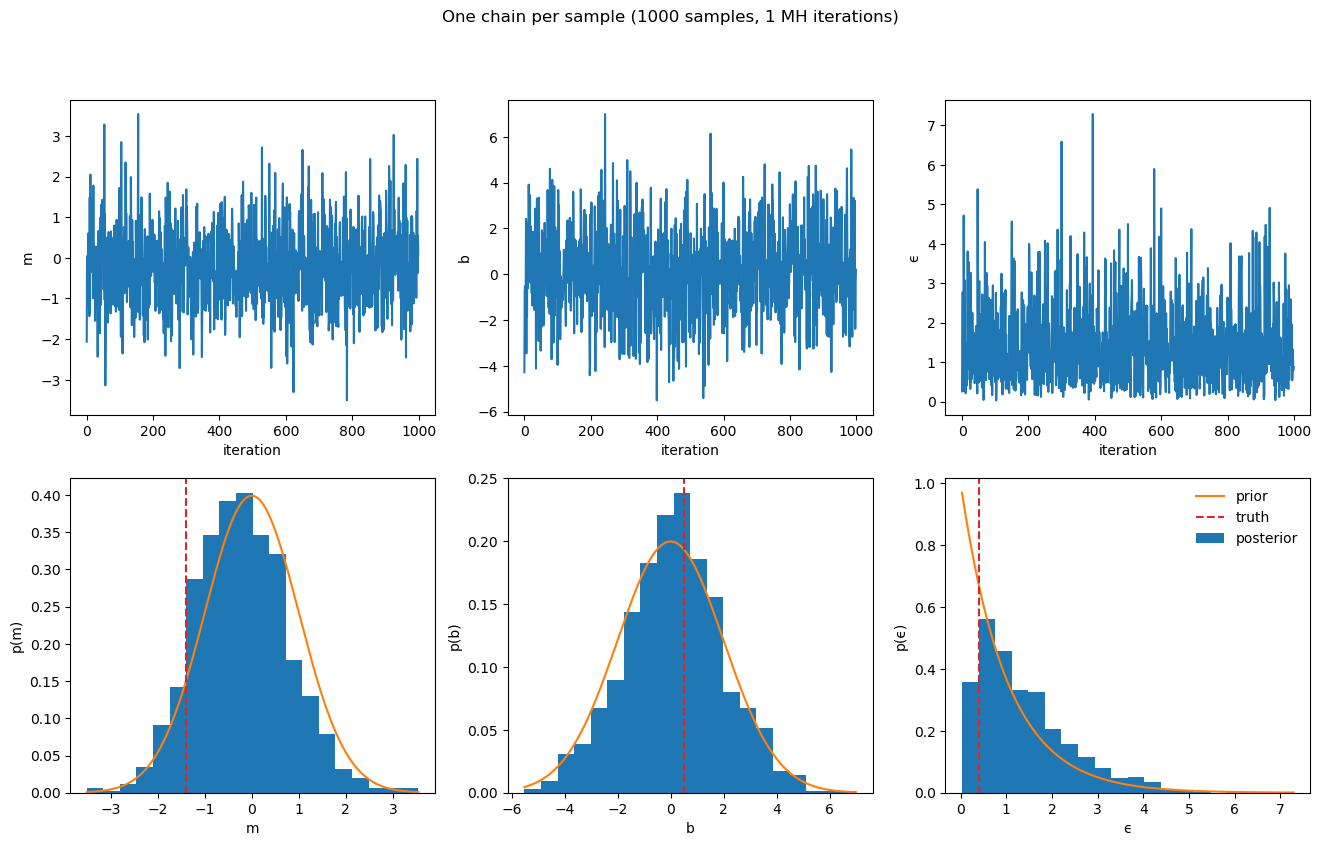

In [107]:
infer_and_plot_one_chain_per_sample(xs, ys, n_samples=1000, mh_iters=1, truth=(m′, b′, ϵ′), bins=20);

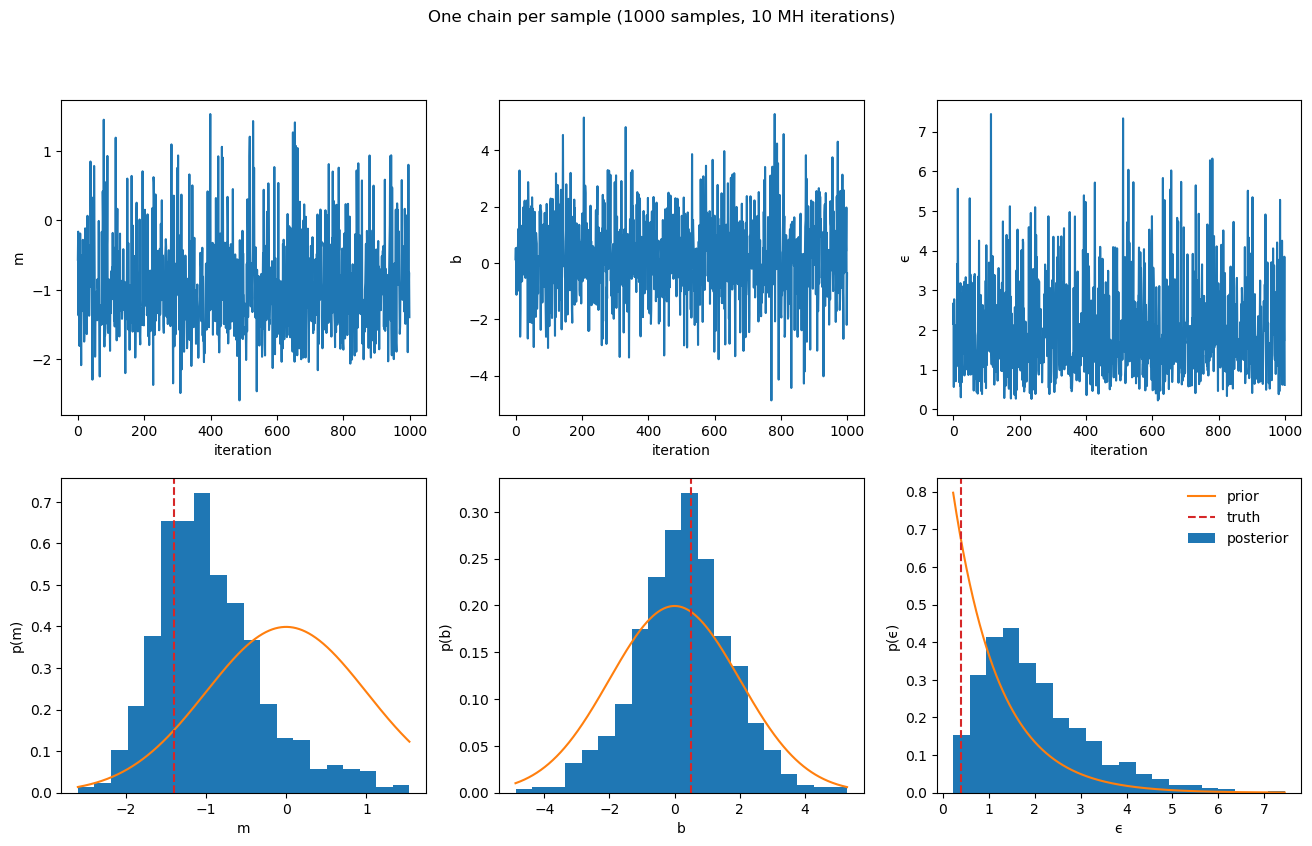

In [108]:
infer_and_plot_one_chain_per_sample(xs, ys, n_samples=1000, mh_iters=10, truth=(m′, b′, ϵ′), bins=20);

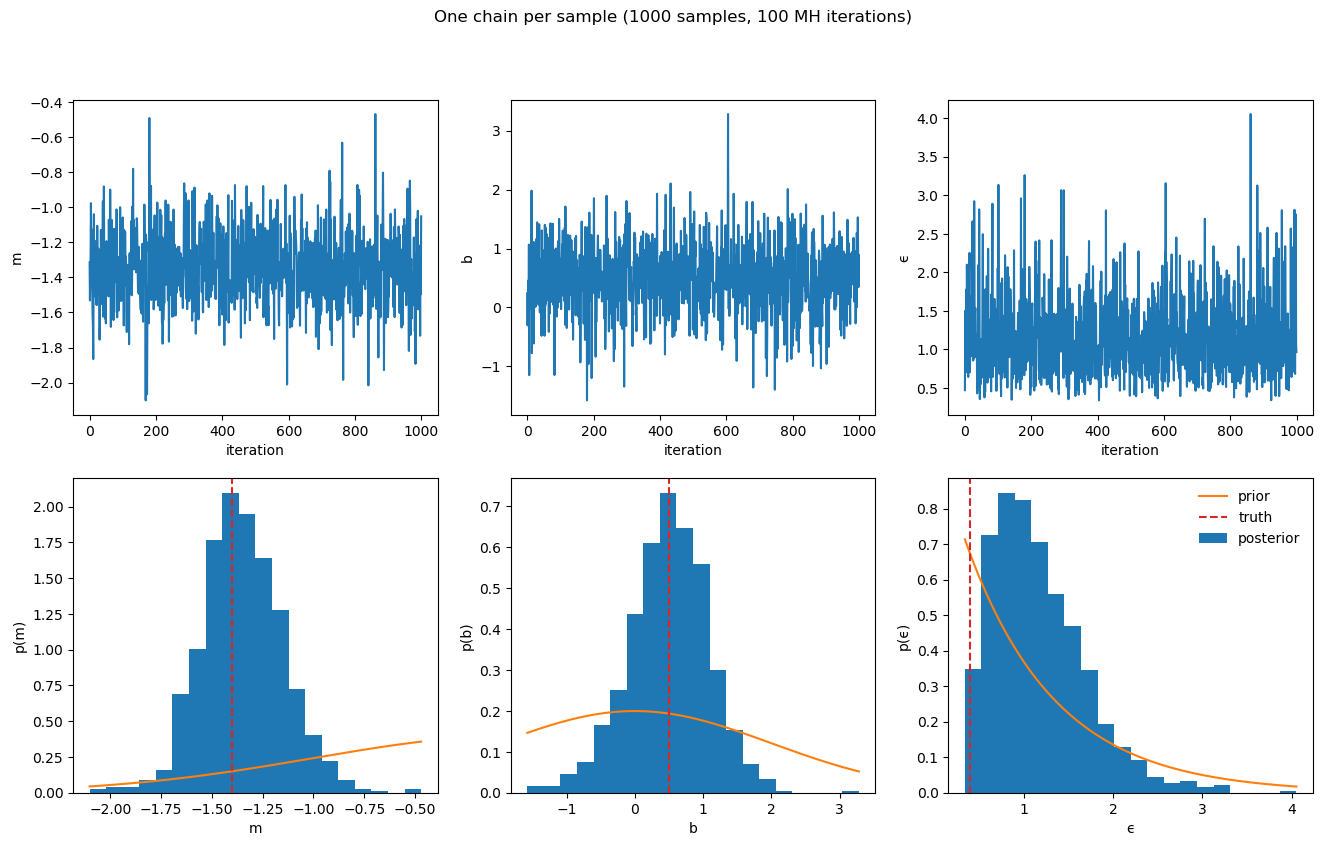

In [109]:
infer_and_plot_one_chain_per_sample(xs, ys, n_samples=1000, mh_iters=100, truth=(m′, b′, ϵ′), bins=20);

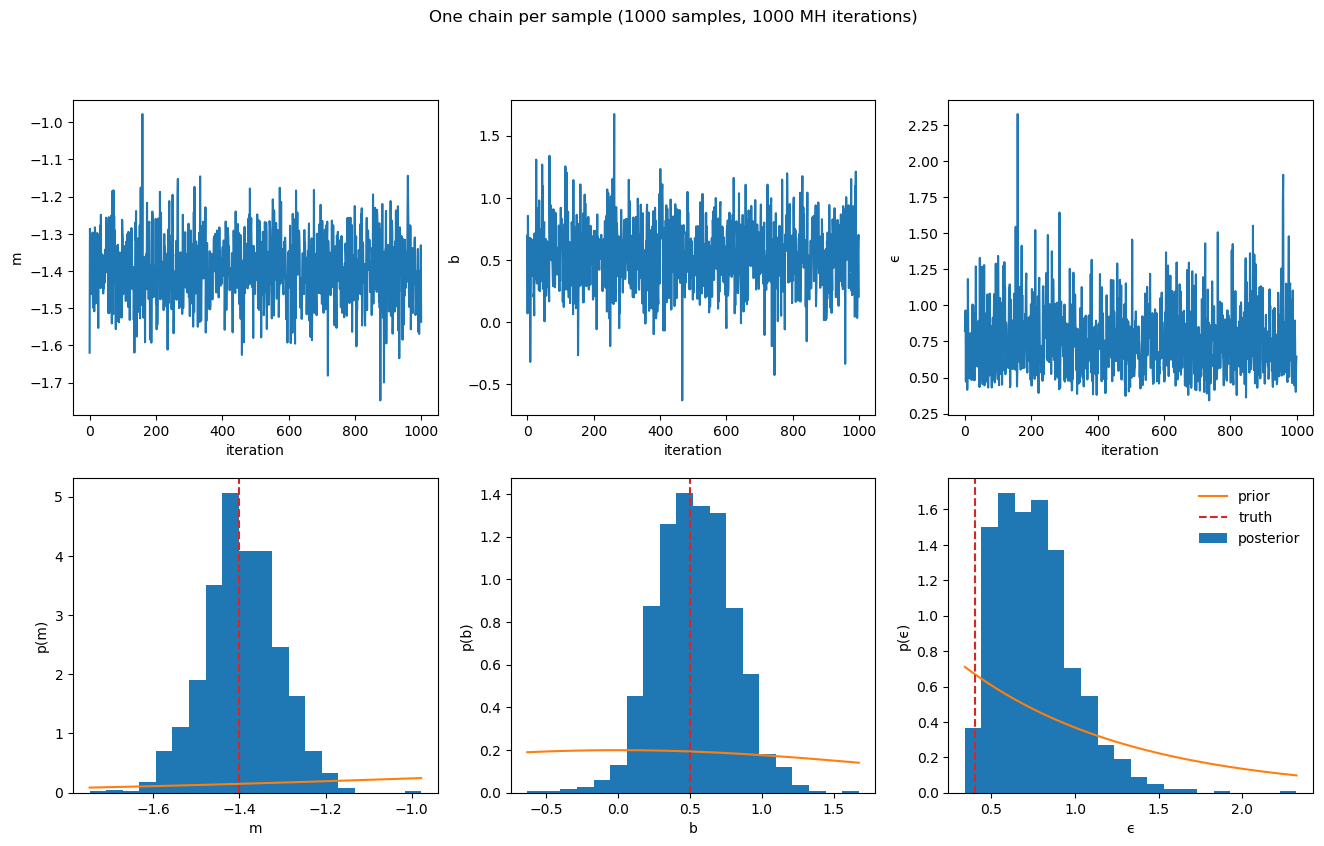

In [110]:
infer_and_plot_one_chain_per_sample(xs, ys, n_samples=1000, mh_iters=1000, truth=(m′, b′, ϵ′), bins=20);

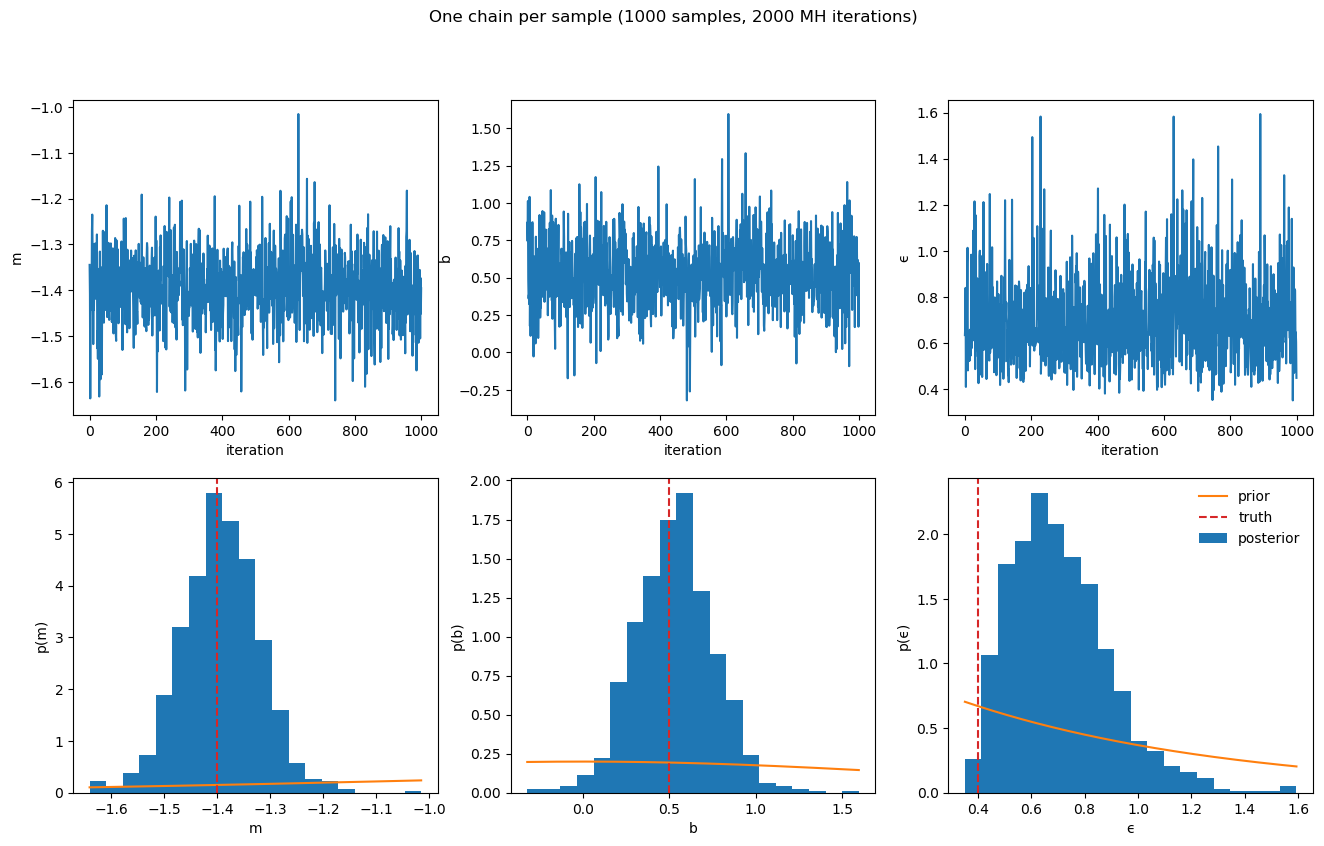

In [111]:
infer_and_plot_one_chain_per_sample(xs, ys, n_samples=1000, mh_iters=2000, truth=(m′, b′, ϵ′), bins=20);

In [146]:
function infer_line_model_parameters_all_samples_from_same_chain(xs, ys; n_samples)
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    line_model_params = Gen.select(:m, :b, :ϵ)
    
    ms = zeros(n_samples)
    bs = zeros(n_samples)
    ϵs = zeros(n_samples)
    
    n_mh_steps = 0
    n_accepted_steps = 0
    
    trace, _ = Gen.generate(line_model, (xs,), observations)
    while n_accepted_steps < n_samples
        trace, accepted = metropolis_hastings(trace, line_model_params, observations=observations)
        if accepted
            n_accepted_steps = n_accepted_steps + 1
            
            choices = Gen.get_choicesPyrus (trace)
            ms[n_accepted_steps] = choices[:m]
            bs[n_accepted_steps] = choices[:b]
            ϵs[n_accepted_steps] = choices[:ϵ]
        end
        n_mh_steps = n_mh_steps + 1
    end
    
    println("# of accepted steps: $n_accepted_steps")
    println("# of MH steps: $n_mh_steps")
    println("Acceptence ratio: $(n_accepted_steps/n_mh_steps)")
    
    return ms, bs, ϵs
end

infer_line_model_parameters_all_samples_from_same_chain (generic function with 1 method)

In [147]:
function infer_and_plot_all_samples_from_same_chain(xs, ys; n_samples, truth, bins=10)
    ms, bs, ϵs = infer_line_model_parameters_all_samples_from_same_chain(xs, ys, n_samples=n_samples)
    
    fig, axes = PyPlot.subplots(nrows=2, ncols=3, figsize=(16, 9))
    fig.suptitle("All samples from the same chain ($n_samples samples)")

    plot_inference!(axes, xs, ys, ms, bs, ϵs, truth, bins)
    
    return ms, bs, ϵs
end

infer_and_plot_all_samples_from_same_chain (generic function with 1 method)

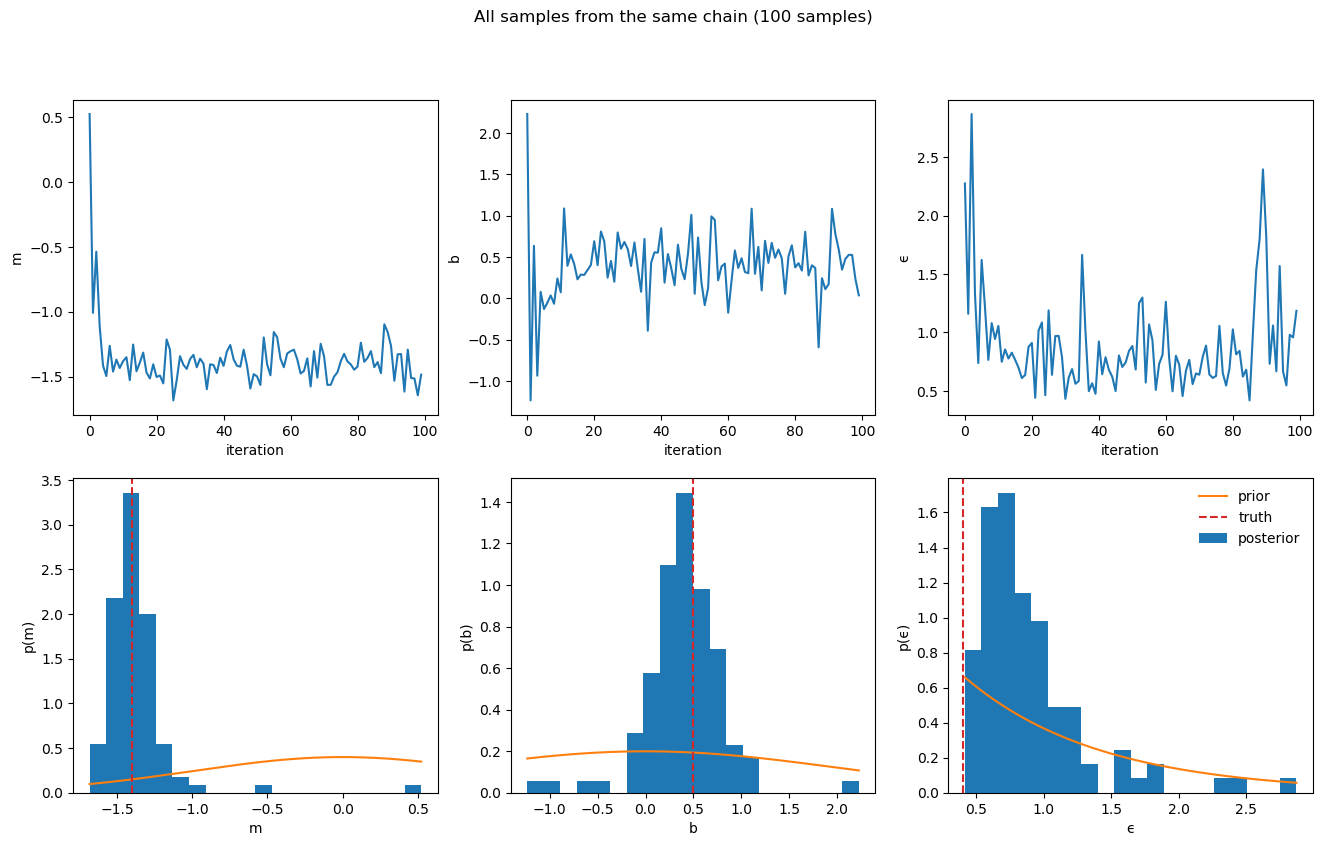

# of accepted steps: 100
# of MH steps: 57848
Acceptence ratio: 0.0017286682339925322


In [148]:
infer_and_plot_all_samples_from_same_chain(xs, ys, n_samples=100, truth=(m′, b′, ϵ′), bins=20);

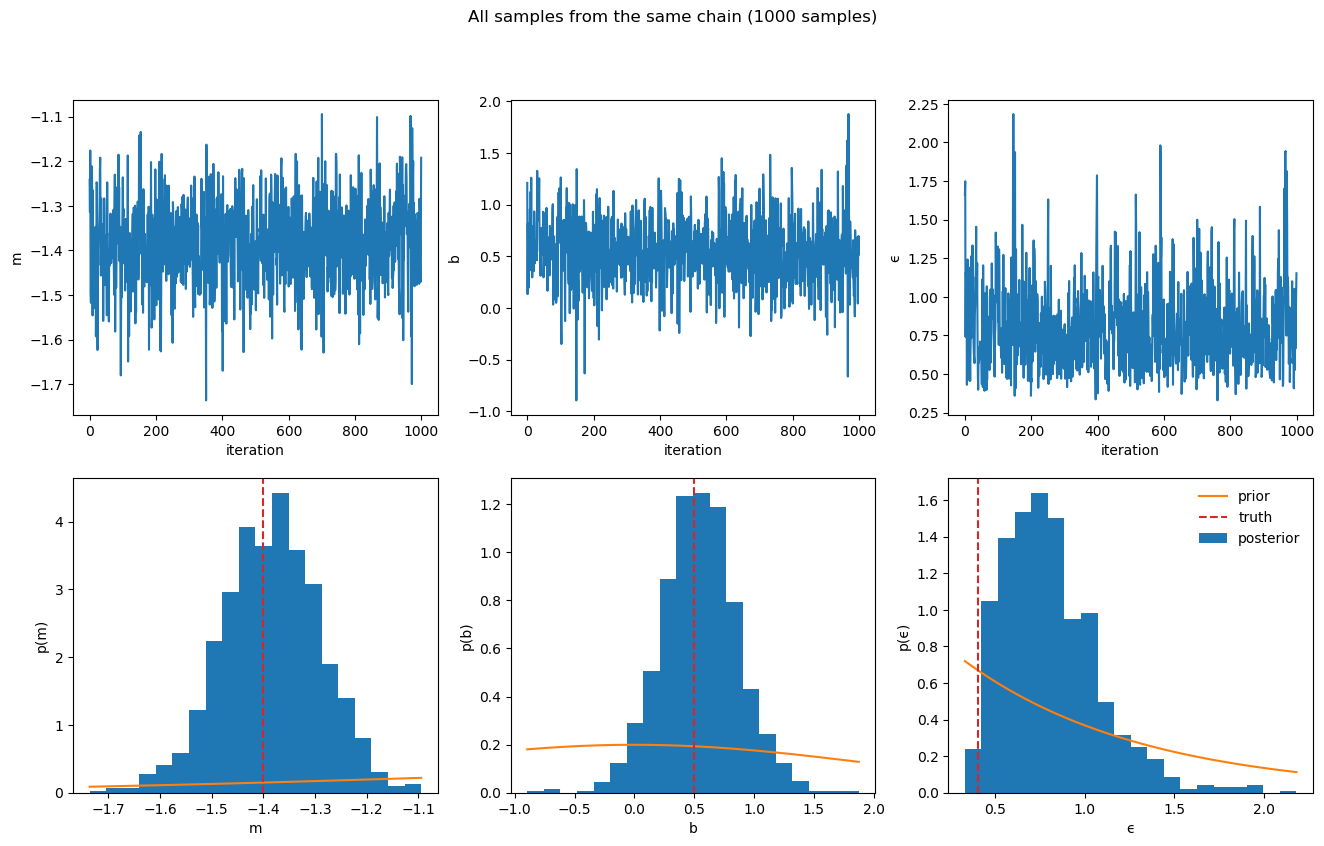

# of accepted steps: 1000
# of MH steps: 531617
Acceptence ratio: 0.0018810534651826408


In [149]:
infer_and_plot_all_samples_from_same_chain(xs, ys, n_samples=1000, truth=(m′, b′, ϵ′), bins=20);

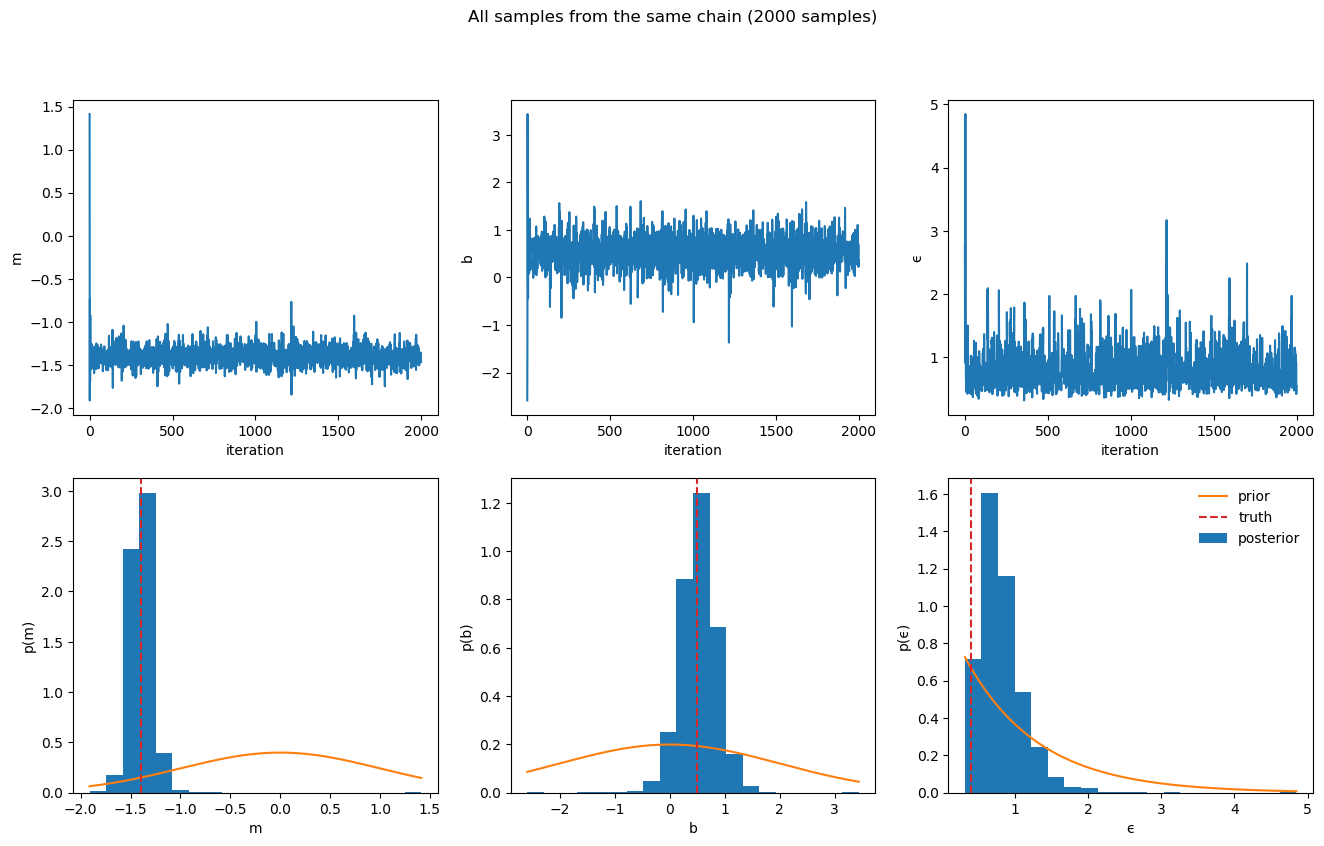

# of accepted steps: 2000
# of MH steps: 1222407
Acceptence ratio: 0.0016361162853288634


In [134]:
infer_and_plot_all_samples_from_same_chain(xs, ys, n_samples=2000, truth=(m′, b′, ϵ′), bins=20);

In [153]:
@gen function line_proposal(trace)
    m ~ normal(trace[:m], 0.01)
    b ~ normal(trace[:b], 0.01)
    ϵ ~ normal(trace[:ϵ], 0.01)
    return nothing
end

function infer_line_model_parameters_all_samples_from_same_chain_gaussian_drift(xs, ys; n_samples)
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    ms = zeros(n_samples)
    bs = zeros(n_samples)
    ϵs = zeros(n_samples)
    
    n_mh_steps = 0
    n_accepted_steps = 0
    
    trace, _ = Gen.generate(line_model, (xs,), observations)
    while n_accepted_steps < n_samples
        trace, accepted = metropolis_hastings(trace, line_proposal, (), observations=observations)
        if accepted
            n_accepted_steps = n_accepted_steps + 1
            choices = Gen.get_choices(trace)
            ms[n_accepted_steps] = choices[:m]
            bs[n_accepted_steps] = choices[:b]
            ϵs[n_accepted_steps] = choices[:ϵ]
        end
        n_mh_steps = n_mh_steps + 1
    end
    
    println("# of accepted steps: $n_accepted_steps")
    println("# of MH steps: $n_mh_steps")
    println("Acceptence ratio: $(n_accepted_steps/n_mh_steps)")
    
    return ms, bs, ϵs
end

function infer_and_plot_all_samples_from_same_chain_gaussian_drift(xs, ys; n_samples, truth, bins=10)
    ms, bs, ϵs = infer_line_model_parameters_all_samples_from_same_chain(xs, ys, n_samples=n_samples)
    
    fig, axes = PyPlot.subplots(nrows=2, ncols=3, figsize=(16, 9))
    fig.suptitle("All samples from the same chain (Gaussian drift proposal, $n_samples samples)")

    plot_inference!(axes, xs, ys, ms, bs, ϵs, truth, bins)
    
    return ms, bs, ϵs
end

infer_and_plot_all_samples_from_same_chain_gaussian_drift (generic function with 1 method)

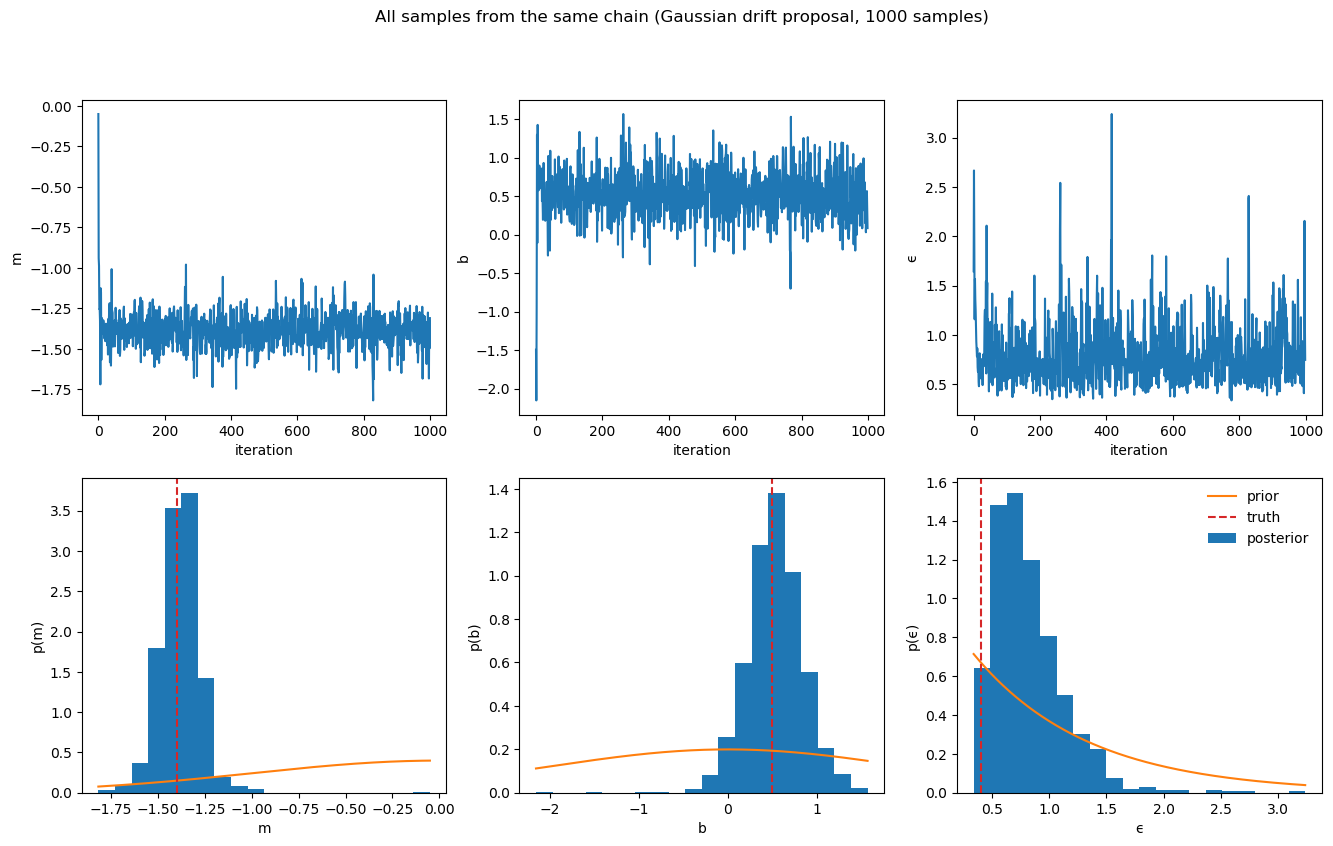

# of accepted steps: 1000
# of MH steps: 595542
Acceptence ratio: 0.0016791426969046683


In [151]:
infer_and_plot_all_samples_from_same_chain_gaussian_drift(xs, ys, n_samples=1000, truth=(m′, b′, ϵ′), bins=20);

In [195]:
function infer_line_model_parameters_hmc(xs, ys; n_samples, max_iters)
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    line_model_params = Gen.select(:m, :b, :ϵ)
    
    ms = zeros(n_samples)
    bs = zeros(n_samples)
    ϵs = zeros(n_samples)
    
    n_hmc_steps = 0
    n_accepted_steps = 0
    
    trace, _ = Gen.generate(line_model, (xs,), observations)
    while n_accepted_steps < n_samples
        trace, accepted = Gen.hmc(trace, line_model_params, eps=0.01, observations=observations)
        if accepted
            n_accepted_steps = n_accepted_steps + 1
            choices = Gen.get_choices(trace)
            ms[n_accepted_steps] = choices[:m]
            bs[n_accepted_steps] = choices[:b]
            ϵs[n_accepted_steps] = choices[:ϵ]
        end
        n_hmc_steps = n_hmc_steps + 1
        n_hmc_steps > max_iters && break
    end
    
    println("# of accepted steps: $n_accepted_steps")
    println("# of HMC steps: $n_hmc_steps")
    println("Acceptence ratio: $(n_accepted_steps/n_hmc_steps)")
    
    return ms, bs, ϵs
end

function infer_and_plot_hmc(xs, ys; n_samples, max_iters, truth, bins=10)
    ms, bs, ϵs = infer_line_model_parameters_hmc(xs, ys, n_samples=n_samples, max_iters=max_iters)
    
    fig, axes = PyPlot.subplots(nrows=2, ncols=3, figsize=(16, 9))
    fig.suptitle("Hamiltonian Monte Carlo ($(length(ms)) samples)")

    plot_inference!(axes, xs, ys, ms, bs, ϵs, truth, bins)
    
    return ms, bs, ϵs
end

infer_and_plot_hmc (generic function with 1 method)

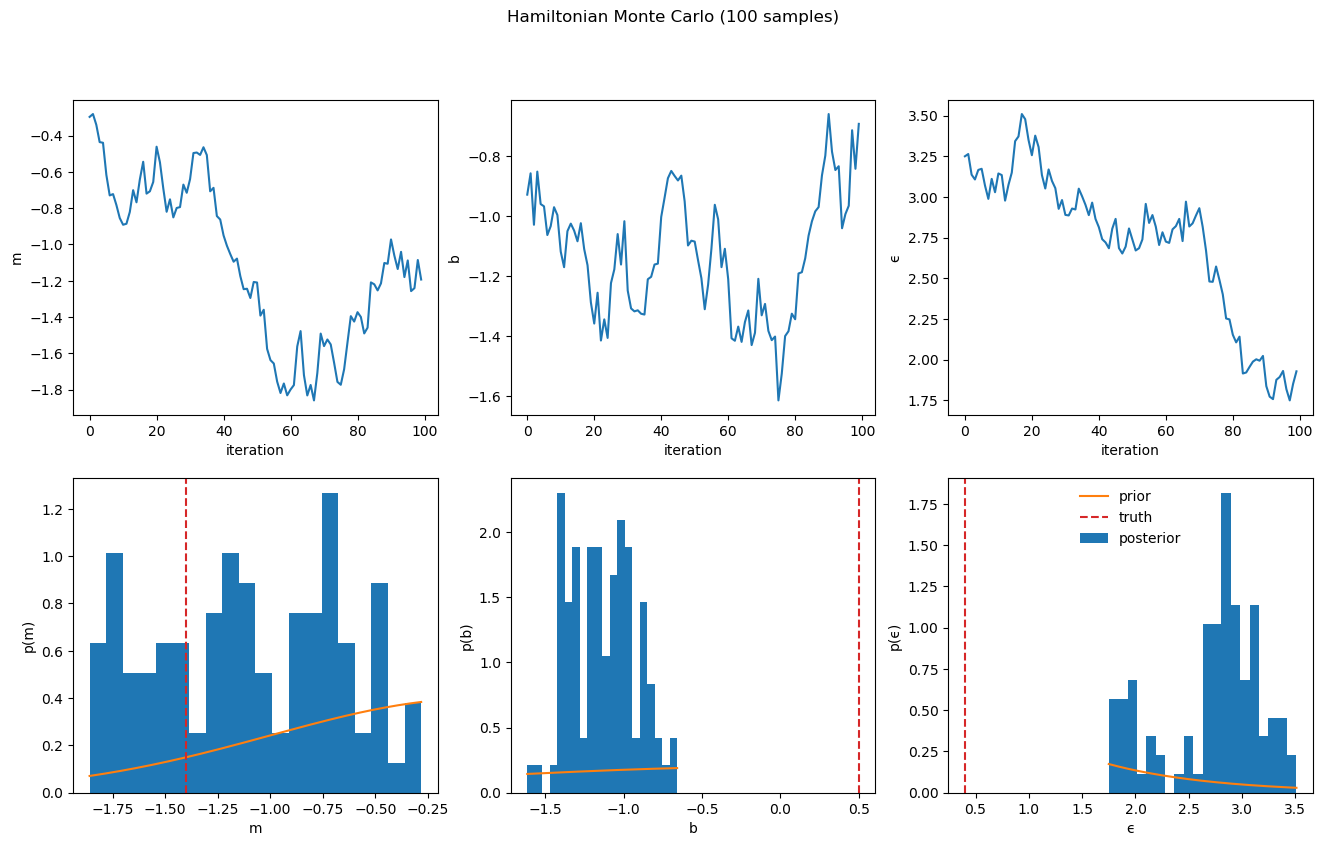

# of accepted steps: 100
# of HMC steps: 100
Acceptence ratio: 1.0


In [204]:
infer_and_plot_hmc(xs, ys, n_samples=100, max_iters=200, truth=(m′, b′,ϵ′), bins=20);

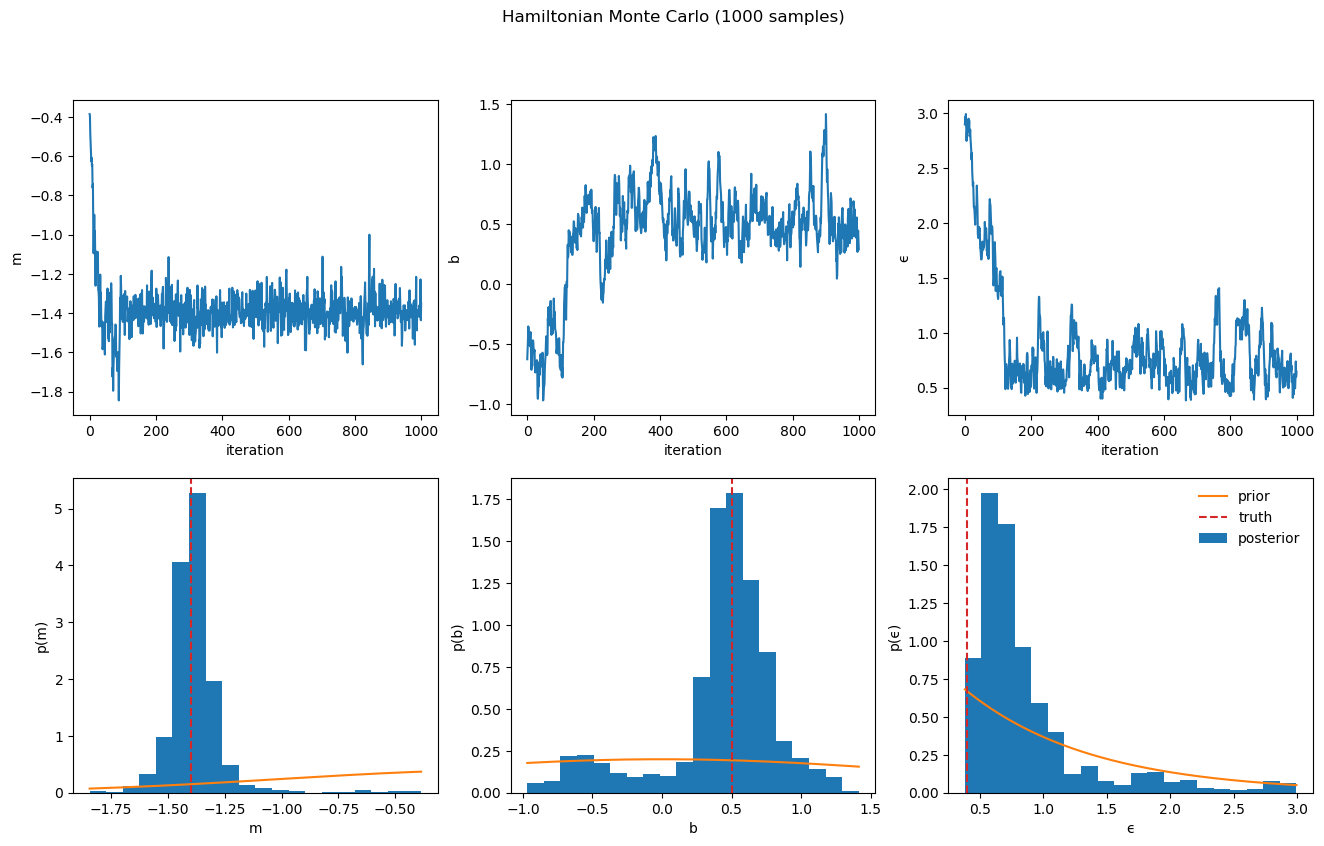

# of accepted steps: 1000
# of HMC steps: 1003
Acceptence ratio: 0.9970089730807578


In [202]:
infer_and_plot_hmc(xs, ys, n_samples=1000, max_iters=2000, truth=(m′, b′,ϵ′), bins=20);

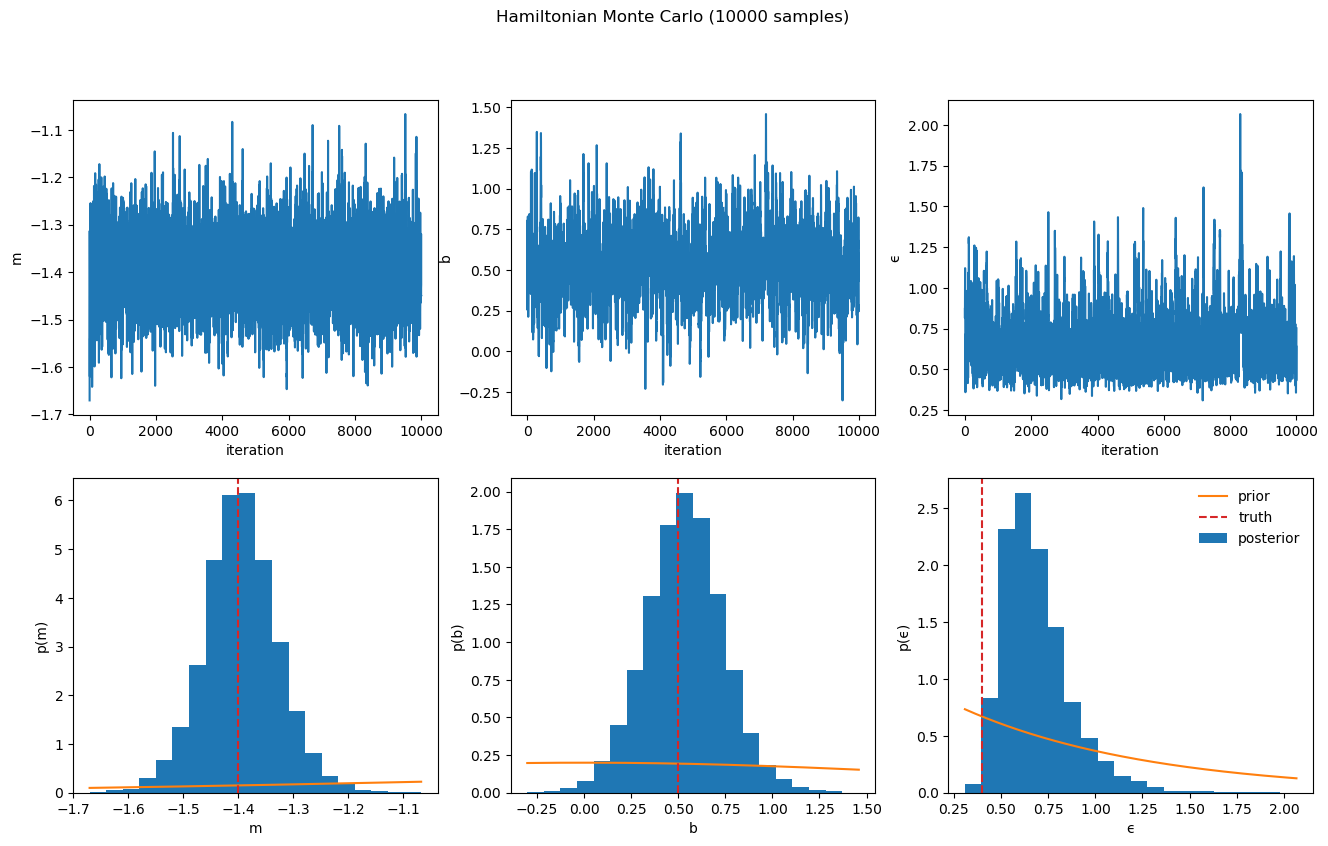

# of accepted steps: 10000
# of HMC steps: 10020
Acceptence ratio: 0.998003992015968


In [203]:
infer_and_plot_hmc(xs, ys, n_samples=10000, max_iters=20000, truth=(m′, b′,ϵ′), bins=20);

In [210]:
function infer_line_model_parameters_1d_mh(xs, ys; n_samples)
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    ms = zeros(n_samples)
    bs = zeros(n_samples)
    ϵs = zeros(n_samples)
    
    n_mh_steps = 0
    n_accepted_steps = 0
    
    trace, _ = Gen.generate(line_model, (xs,), observations)
    while n_accepted_steps < n_samples
        for param in (:m, :b, :ϵ)
            trace, accepted = metropolis_hastings(trace, Gen.select(param), observations=observations)
            if accepted
                n_accepted_steps = n_accepted_steps + 1

                choices = Gen.get_choices(trace)
                ms[n_accepted_steps] = choices[:m]
                bs[n_accepted_steps] = choices[:b]
                ϵs[n_accepted_steps] = choices[:ϵ]
            end
            n_mh_steps = n_mh_steps + 1
        end
    end
    
    println("# of accepted steps: $n_accepted_steps")
    println("# of MH steps: $n_mh_steps")
    println("Acceptence ratio: $(n_accepted_steps/n_mh_steps)")
    
    return ms, bs, ϵs
end

function infer_and_plot_1d_mh(xs, ys; n_samples, truth, bins=10)
    ms, bs, ϵs = infer_line_model_parameters_1d_mh(xs, ys, n_samples=n_samples)
    
    fig, axes = PyPlot.subplots(nrows=2, ncols=3, figsize=(16, 9))
    fig.suptitle("1D MH ($(length(ms)) samples)")

    plot_inference!(axes, xs, ys, ms, bs, ϵs, truth, bins)
    
    return ms, bs, ϵs
end

infer_and_plot_1d_mh (generic function with 1 method)

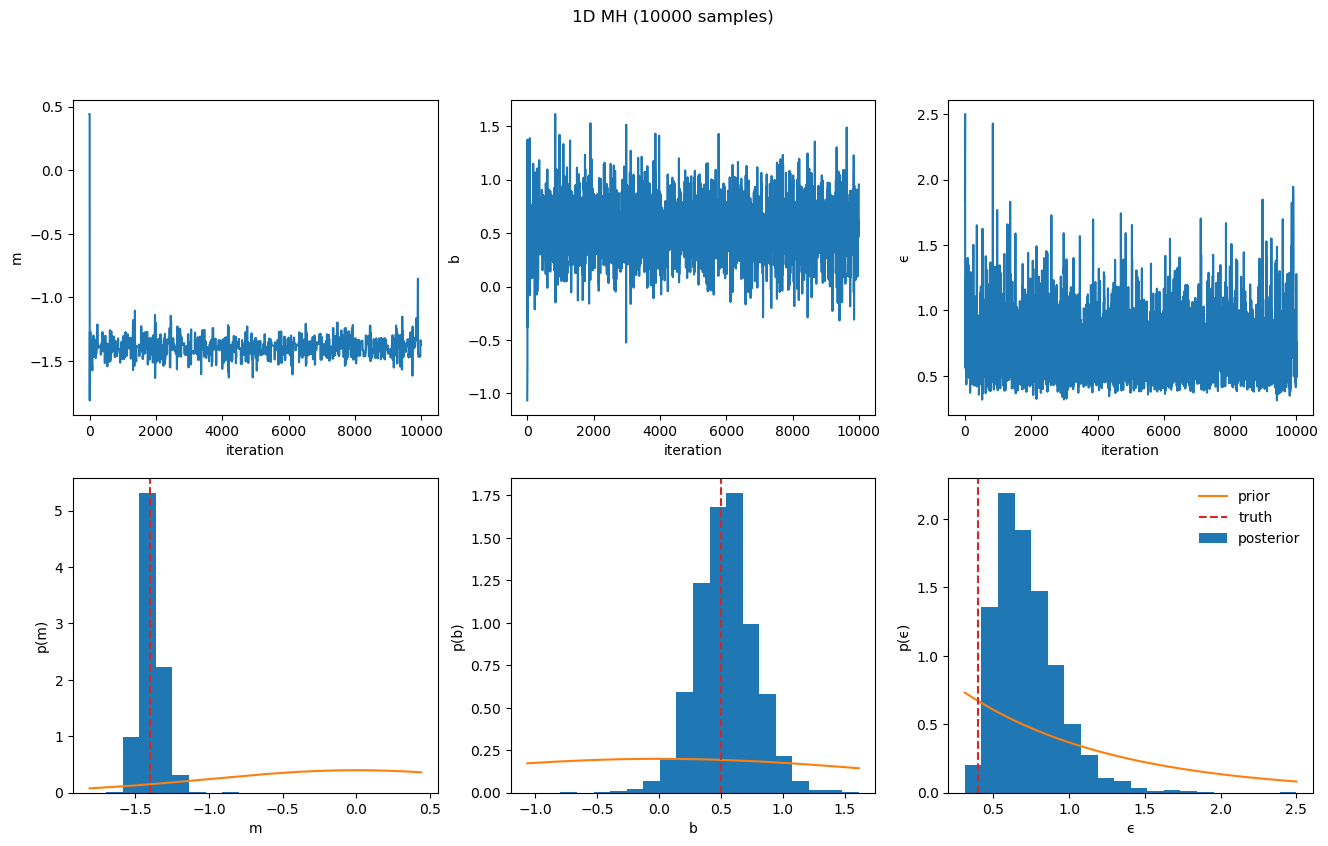

# of accepted steps: 10000
# of MH steps: 77397
Acceptence ratio: 0.1292039743142499


In [213]:
infer_and_plot_1d_mh(xs, ys, n_samples=10000, truth=(m′, b′,ϵ′), bins=20);